In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns
import pandas as pd
from skimage.filters import sobel

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.path.abspath(os.getcwd())

'/content'

# Pre-Processing data

In [ ]:
import os
import shutil
import random

# Path to your dataset
data_path = "/content/drive/MyDrive/Colab Notebooks/facial/dataset"
types = ['Ahegao', 'Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Destination folders
train_folder = os.path.join(data_path, 'train')
test_folder = os.path.join(data_path, 'test')

# Create subdirectories in train, val, and test folders
for folder in [train_folder, test_folder]:
    for t in types:
        os.makedirs(os.path.join(folder, t), exist_ok=True)

# Define split proportions
train_split = 0.80
test_split = 0.20

# Define a list of image extensions
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

for t in types:
    # Path to type-specific folder
    type_folder = os.path.join(data_path, t)

    # List of images in the type folder
    images = [img for img in os.listdir(type_folder) if os.path.splitext(img)[-1].lower() in image_extensions]
    random.shuffle(images)  # Shuffle to randomize

    # Determine split indices
    train_idx = int(len(images) * train_split)

    # Split images into train, val, and test sets
    train_imgs = images[:train_idx]
    test_imgs = images[train_idx:]

    # Function to copy images to destination folder
    def copy_images(images, destination):
        for img in images:
            src = os.path.join(type_folder, img)
            dst = os.path.join(destination, t, img)
            shutil.copy(src, dst)

    # Copy images to respective directories
    copy_images(train_imgs, train_folder)
    copy_images(test_imgs, test_folder)

# Creating labels


In [2]:
SIZE = 256
image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
train_imgs = []
train_labels = []
for directory_path in glob.glob('/content/drive/MyDrive/Colab Notebooks/facial/dataset/train/*'):
    label = directory_path.split('/')[-1]
    for extension in image_extensions:
        for img_path in glob.glob(os.path.join(directory_path,extension)):
            img = cv2.imread(img_path,cv2.IMREAD_COLOR)
            img = cv2.resize(img,(SIZE,SIZE))
            train_imgs.append(img)
            train_labels.append(label)


In [3]:
train_imgs = np.array(train_imgs)
train_labels = np.array(train_labels)

In [4]:
SIZE = 256
image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
test_imgs = []
test_labels = []
for directory_path in glob.glob('/content/drive/MyDrive/Colab Notebooks/facial/dataset/test/*'):
    label = directory_path.split('/')[-1]
    for extension in image_extensions:
        for img_path in glob.glob(os.path.join(directory_path,extension)):
            img = cv2.imread(img_path,cv2.IMREAD_COLOR)
            img = cv2.resize(img,(SIZE,SIZE))
            test_imgs.append(img)
            test_labels.append(label)


In [5]:
test_imgs = np.array(test_imgs)
test_labels = np.array(test_labels)

In [6]:
from sklearn.preprocessing import LabelEncoder
##
encoded_y_train = LabelEncoder()
encoded_y_train = encoded_y_train.fit_transform(train_labels)
##
encoded_y_test = LabelEncoder()
encoded_y_test = encoded_y_test.fit_transform(test_labels)


In [7]:
x_train, y_train, x_test, y_test = train_imgs, encoded_y_train, test_imgs, encoded_y_test

In [8]:
x_train, x_test  = x_train/255, x_test/255

# Extracting features from images using VGG16

In [9]:

from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications.vgg16 import VGG16
model_vgg16 = VGG16(include_top=False, weights='imagenet')


for layer in model_vgg16.layers:
    layer.trainable = False

feature_extractor1 = model_vgg16.predict(x_train)
feature_extractor3 = model_vgg16.predict(x_test)

126/126 [==============================] - 4s 35ms/step


In [10]:
features1 = feature_extractor1.reshape(feature_extractor1.shape[0], -1)
features3 = feature_extractor3.reshape(feature_extractor3.shape[0], -1)
X_train = features1
X_test = features3

In [11]:
from numba import cuda
device = cuda.get_current_device()
device.reset()

In [12]:
import xgboost as xgb
model = XGBClassifier(learning_rate=0.01,device='cuda',n_estimators=500,objective='multi:softmax')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:25:47] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [13]:
accuracy = accuracy_score(y_test, y_pred) * 100
print("Accuracy: ",accuracy)

Accuracy:  82.32511824744834



#Visualization

In [23]:
le = LabelEncoder()
encoded_y_test = le.fit_transform(test_labels)
predictions = le.inverse_transform(y_pred)
y_test = le.inverse_transform(y_test)


<Axes: >

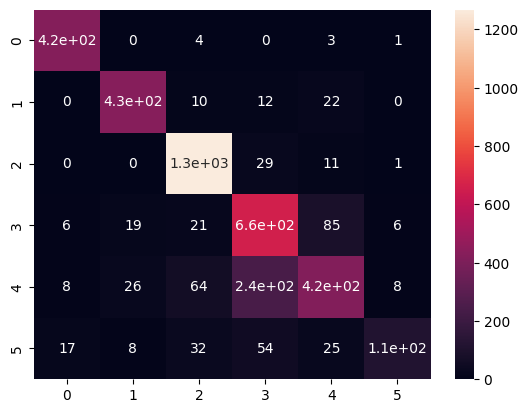

In [26]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test,predictions)
sns.heatmap(confusion,annot=True)

The prediction of this image is: Happy
The actual label for this image is: Happy


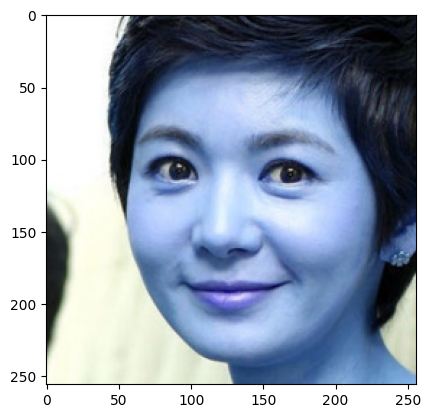

In [80]:
n = np.random.randint(0,x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(X_test[n],axis=0)
input_img_feature = model.predict(input_img)
prediction = le.inverse_transform(input_img_feature)
print('The prediction of this image is:',prediction[0])
print('The actual label for this image is:',y_test[n])

# Now that's a wrap!